In [1]:
import requests
import pandas as pd
from time import sleep
from tqdm import tqdm
from SPARQLWrapper import SPARQLWrapper, JSON

<h1> The first visualization that we would like to perform is to compare the sizes of artwork collection of  MoMa and Rijksmuseum </h1>
<p> This short visualisation will help us better understand the scope of the ontology and the data which is modeled inside </p>

{'RijksMuseum': 3059, 'Moma': 9000}


<AxesSubplot:title={'center':'Number of Artworks per Museums Database'}>

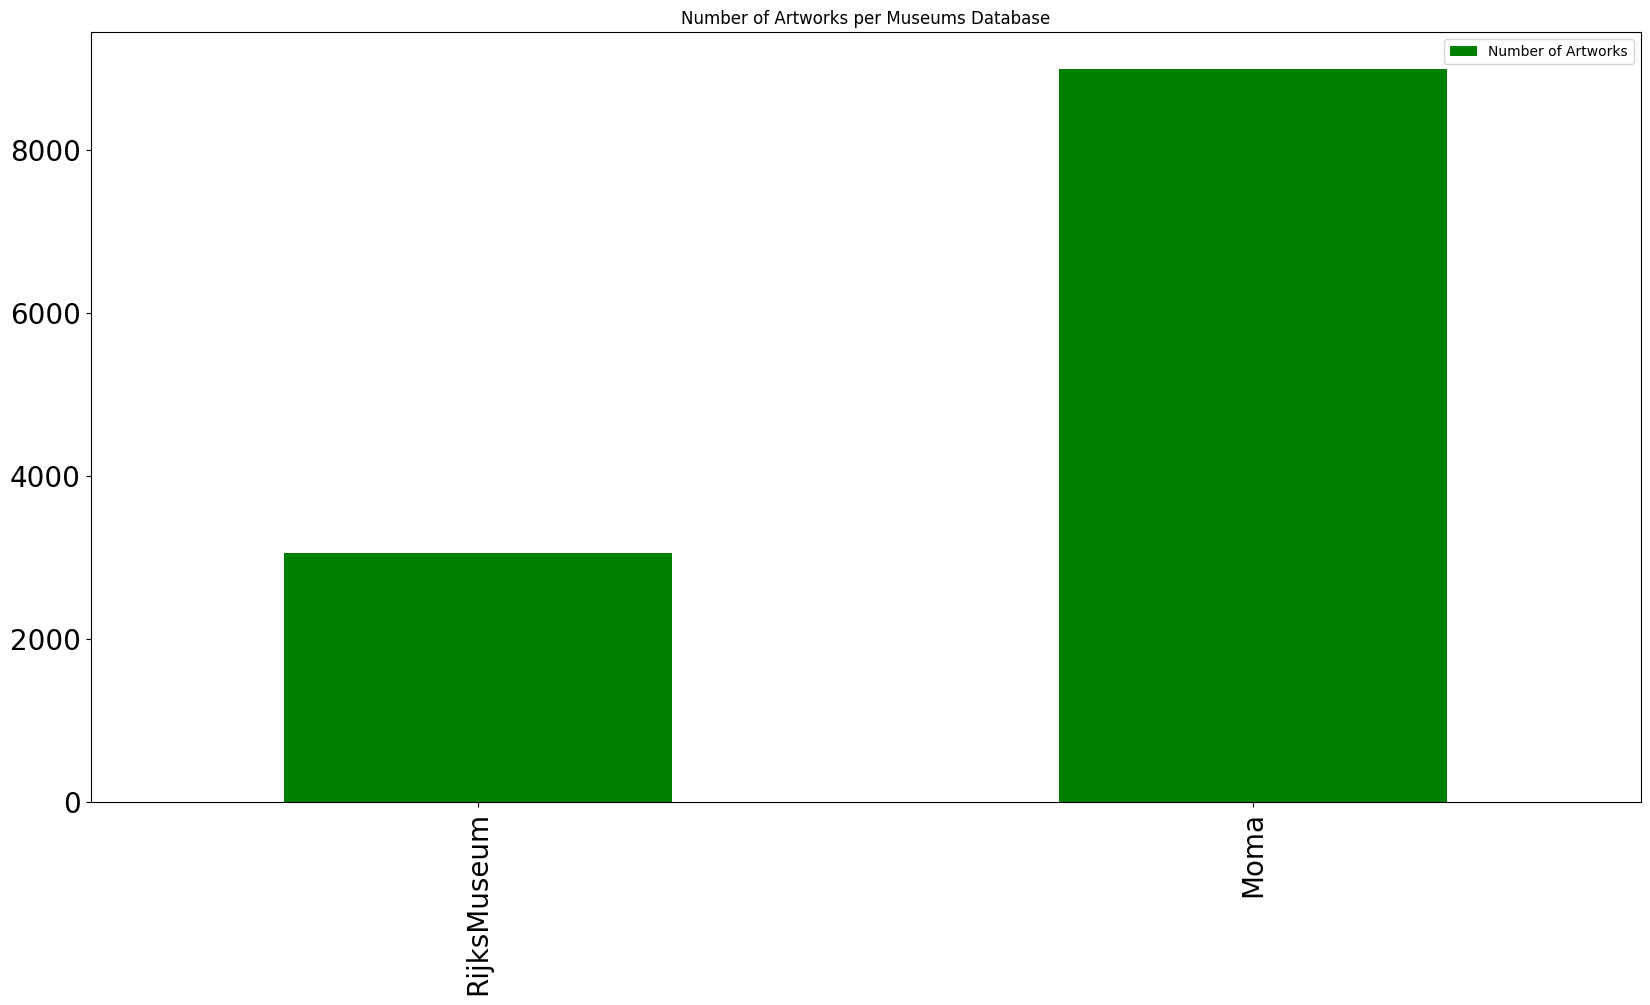

In [2]:
query = """ 

prefix art: <http://www.semanticweb.org/ontologies/2022/9/group_99#> 
prefix owl: <http://www.w3.org/2002/07/owl#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
prefix xml: <http://www.w3.org/XML/1998/namespace> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 


SELECT  ?museum  (count(?x) as  ?number_of_artworks) WHERE { 
?x art:locatedIn ?museum .
}

GROUP BY(?museum)

"""

sparql = SPARQLWrapper("http://localhost:7200/repositories/group_99")


dict = {'RijksMuseum': 0, 'Moma': 0}
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    dict[result["museum"]["value"].split('#')[-1]] = int(result["number_of_artworks"]["value"])

print(dict)

df = pd.DataFrame.from_dict(dict, orient='index', columns=['Number of Artworks'])


df.plot(kind='bar', title='Number of Artworks per Museums Database', figsize=(20, 10), fontsize=20, color=['green'])




<h1> Artsist Data </h1>
<p> This visualisation will show the 100 birth cities that are the most common in our knowledge graph on a map! </p>
<p> Please be patient as collecting the data takes around 20 seconds. </p>

In [3]:
import folium


query = """ prefix art: <http://www.semanticweb.org/ontologies/2022/9/group_99#> 
prefix owl: <http://www.w3.org/2002/07/owl#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
prefix xml: <http://www.w3.org/XML/1998/namespace> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
prefix dbr: <http://dbpedia.org/resource/>
prefix geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

select  ?city (count(?city) as ?number_of_cites) WHERE { 
?artist art:bornIn ?city .
    FILTER(?city != dbr:None && ?city != dbr:none && ?city != dbr:nan)
 

}

GROUP BY(?city)

ORDER BY DESC(?number_of_cites)


LIMIT 100
    
"""
dic    = {}

sparql = SPARQLWrapper("http://localhost:7200/repositories/group_99")
sparql_dbpedia = SPARQLWrapper("http://dbpedia.org/sparql")
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    city = result["city"]["value"].split('/')[-1].split('_')[0]
    
    number = int(result["number_of_cites"]["value"])

    query_2 = """ 

    prefix dbr: <http://dbpedia.org/resource/>
    prefix geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

    select  ?lat ?long WHERE {dbr:""" + city + """ geo:lat ?lat . 
        dbr:""" + city + """ geo:long ?long .}"""
    try:
        sparql_dbpedia.setQuery(query_2)
        sparql_dbpedia.setReturnFormat(JSON)
        results_2 = sparql_dbpedia.query().convert()
        for result_2 in results_2["results"]["bindings"]:
            lat = result_2["lat"]["value"]
            long = result_2["long"]["value"]
            dic[city] = [lat, long, number]

    except:
        pass


df = pd.DataFrame.from_dict(dic, orient='index', columns=['lat', 'long', 'number_of_artists'])



KeyboardInterrupt: 

<h2> First let's show the data on a simple graph </h2>

<AxesSubplot:title={'center':'Number of Artists per City'}>

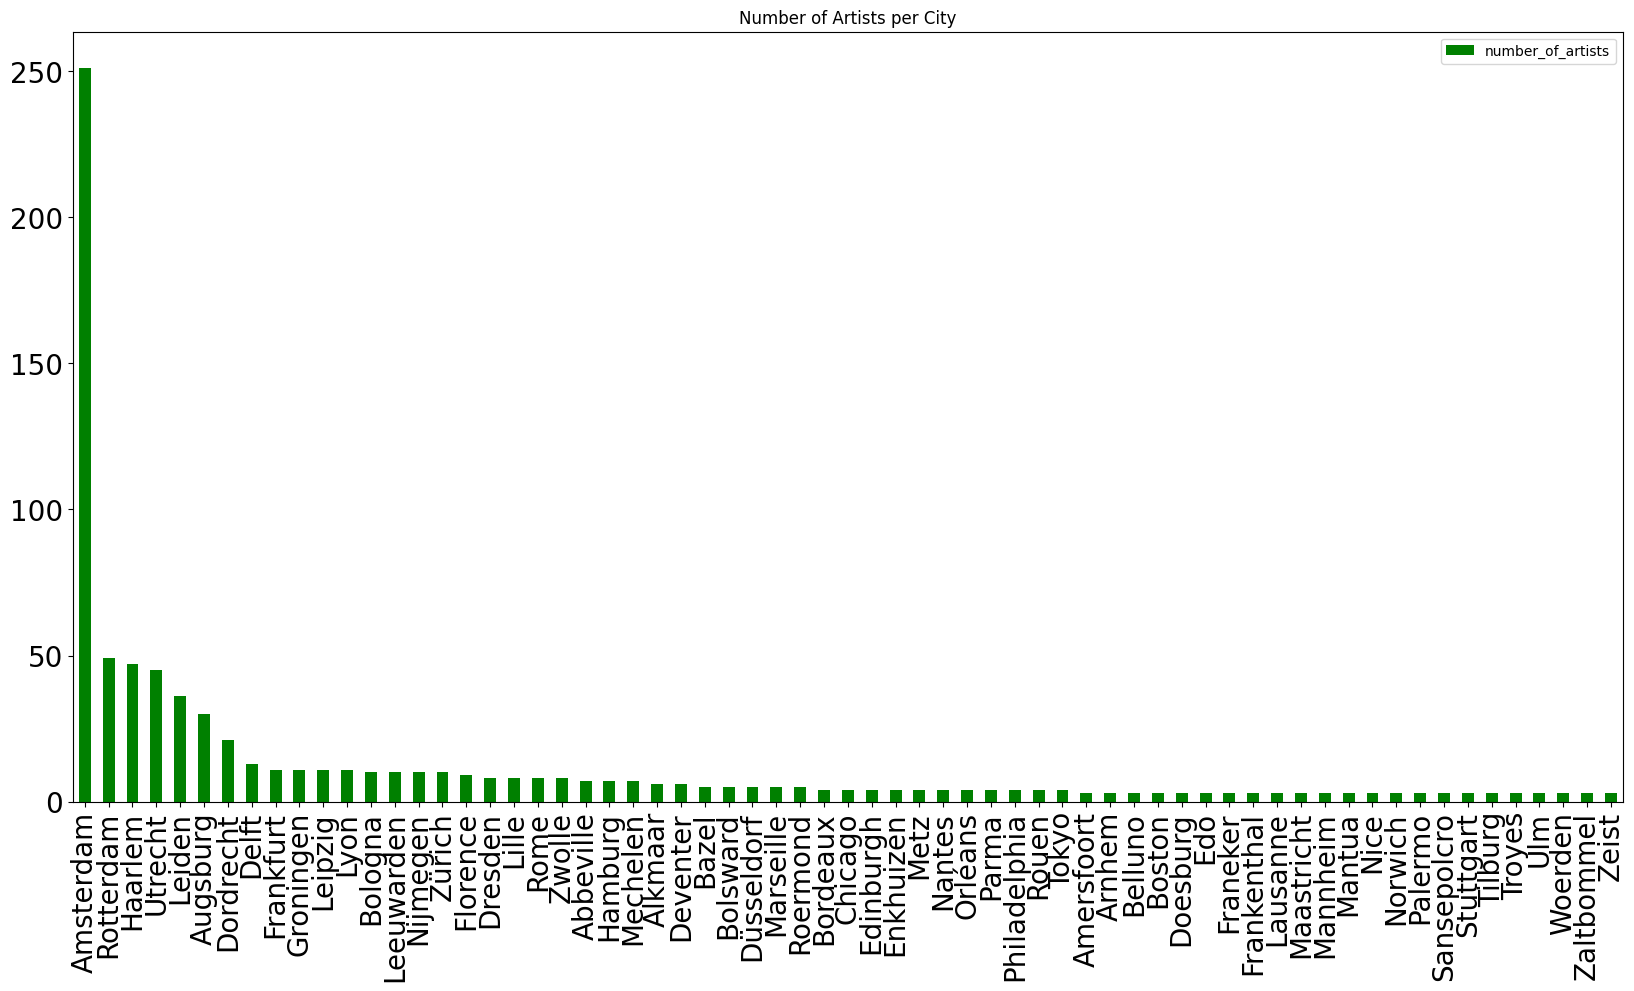

In [ ]:

df.plot.bar(title='Number of Artists per City', figsize=(20, 10), fontsize=20, color=['green'])

<h2> Now let's try displaying the information on a map! </h2>
<p> Since the data is not really well reporesented we wanted to present a more interactive view of the matter</p>
<p> We've created a simple map  with the data of the cities combined with the number of artists that were born in that city </p>
<p> Addidtionally we gathered data about the latidude and longitude of the cities from Dpedia </p>

<h3> A  simple guide to our map</h3>
<ol> 
<li> Hover over a city to see it's name</li>
<li> Click on a city to see the number of artists born in this specific city </li>
<li> The color of the marker indicates the number of artists born in that city with: </li>
<ul>
<li style=" color:red"> Red being the highest number of artists</li>
<li style = "color: orange"> Orange being the second highest number of artists with sizes smaller that 50 but bigger than 10 </li>
<li style = "color: green" > Lastly green for the smaller number of artists.</li>
</ul>
<li> Additionaly on clicking over a city one gets the possiblity to explore it using Dpbedia by just clicking Explore City! (This works correctly when the notebook is opened inside a browser and not an IDE such as VsCode f.e) </li>
<li> If you want to change the map's layout you can always do so by clicking on the icon on the upper right corner. </li>

In [ ]:
def calculate_color(number):
    if number < 10:
        return 'green'
    elif number < 50:
        return 'orange'
    else:
        return 'red'



map = folium.Map(location=[51.507359,-0.136439], zoom_start=5, width=1000, height=500, control_scale=True, tiles='Stamen Watercolor')
folium.raster_layers.TileLayer('Open Street Map').add_to(map)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(map)
folium.raster_layers.TileLayer('Stamen Toner').add_to(map)
folium.raster_layers.TileLayer('Stamen Watercolor').add_to(map)
folium.raster_layers.TileLayer('CartoDB Positron').add_to(map)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(map)
folium.LayerControl().add_to(map)
for (index,row) in df.iterrows():
    folium.Marker(location=[row['lat'], row['long']], icon=folium.Icon(prefix='fa', icon="picture-o", color=(calculate_color(row['number_of_artists']))),radius=row['number_of_artists']/100,tooltip = index ,popup= "<a  target=_blank href=https://dbpedia.org/resource/" + index +">Explore city! </a>" + "Number of artists " + str(row['number_of_artists']), color='red', fill_color='red').add_to(map)

map

<h2> Nationality Data</h2>
<p> We wanted to show the Nationalities of artists of Artists in both RijksMuseum and Moma</p>
<p> Executing this query might again take a while if it takes more than 1 minute we advise to restart the GraphDB instance </p>

In [52]:
query = """ prefix art: <http://www.semanticweb.org/ontologies/2022/9/group_99#> 
prefix owl: <http://www.w3.org/2002/07/owl#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
prefix xml: <http://www.w3.org/XML/1998/namespace> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
prefix dbr: <http://dbpedia.org/resource/>

SELECT ?nationality (count(?nationality) as ?number_of_nationalities) WHERE { 

?artist art:hasNationality ?nationality .
?artist art:made ?artwork .
?artwork art:locatedIn art:RijksMuseum


}
GROUP BY ?nationality 
ORDER BY DESC(?number_of_nationalities)

LIMIT 30  """
dic    = {}

sparql = SPARQLWrapper("http://localhost:7200/repositories/group_99")
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    nationality = result["nationality"]["value"].split('/')[-1]
    number = int(result["number_of_nationalities"]["value"])
    dic[nationality] = [ number]

rijks_df = pd.DataFrame.from_dict(dic, orient='index', columns=[ 'Rijks_number_of_artists'])

In [54]:
moma_query = """ prefix art: <http://www.semanticweb.org/ontologies/2022/9/group_99#> 
prefix owl: <http://www.w3.org/2002/07/owl#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
prefix xml: <http://www.w3.org/XML/1998/namespace> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
prefix dbr: <http://dbpedia.org/resource/>

SELECT ?nationality (count(?nationality) as ?number_of_nationalities) WHERE { 

?artist art:hasNationality ?nationality .
?artist art:made ?artwork .
?artwork art:locatedIn art:Moma


}
GROUP BY ?nationality 
ORDER BY DESC(?number_of_nationalities)

LIMIT 30  """
dic    = {}

sparql = SPARQLWrapper("http://localhost:7200/repositories/group_99")
sparql.setQuery(moma_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    nationality = result["nationality"]["value"].split('/')[-1]
    number = int(result["number_of_nationalities"]["value"])
    dic[nationality] = [number]

moma_df = pd.DataFrame.from_dict(dic, orient='index', columns=[ 'Moma_number_of_artists'])



<AxesSubplot:title={'center':'Number of Artists by Nationality Represented in the two Museums'}>

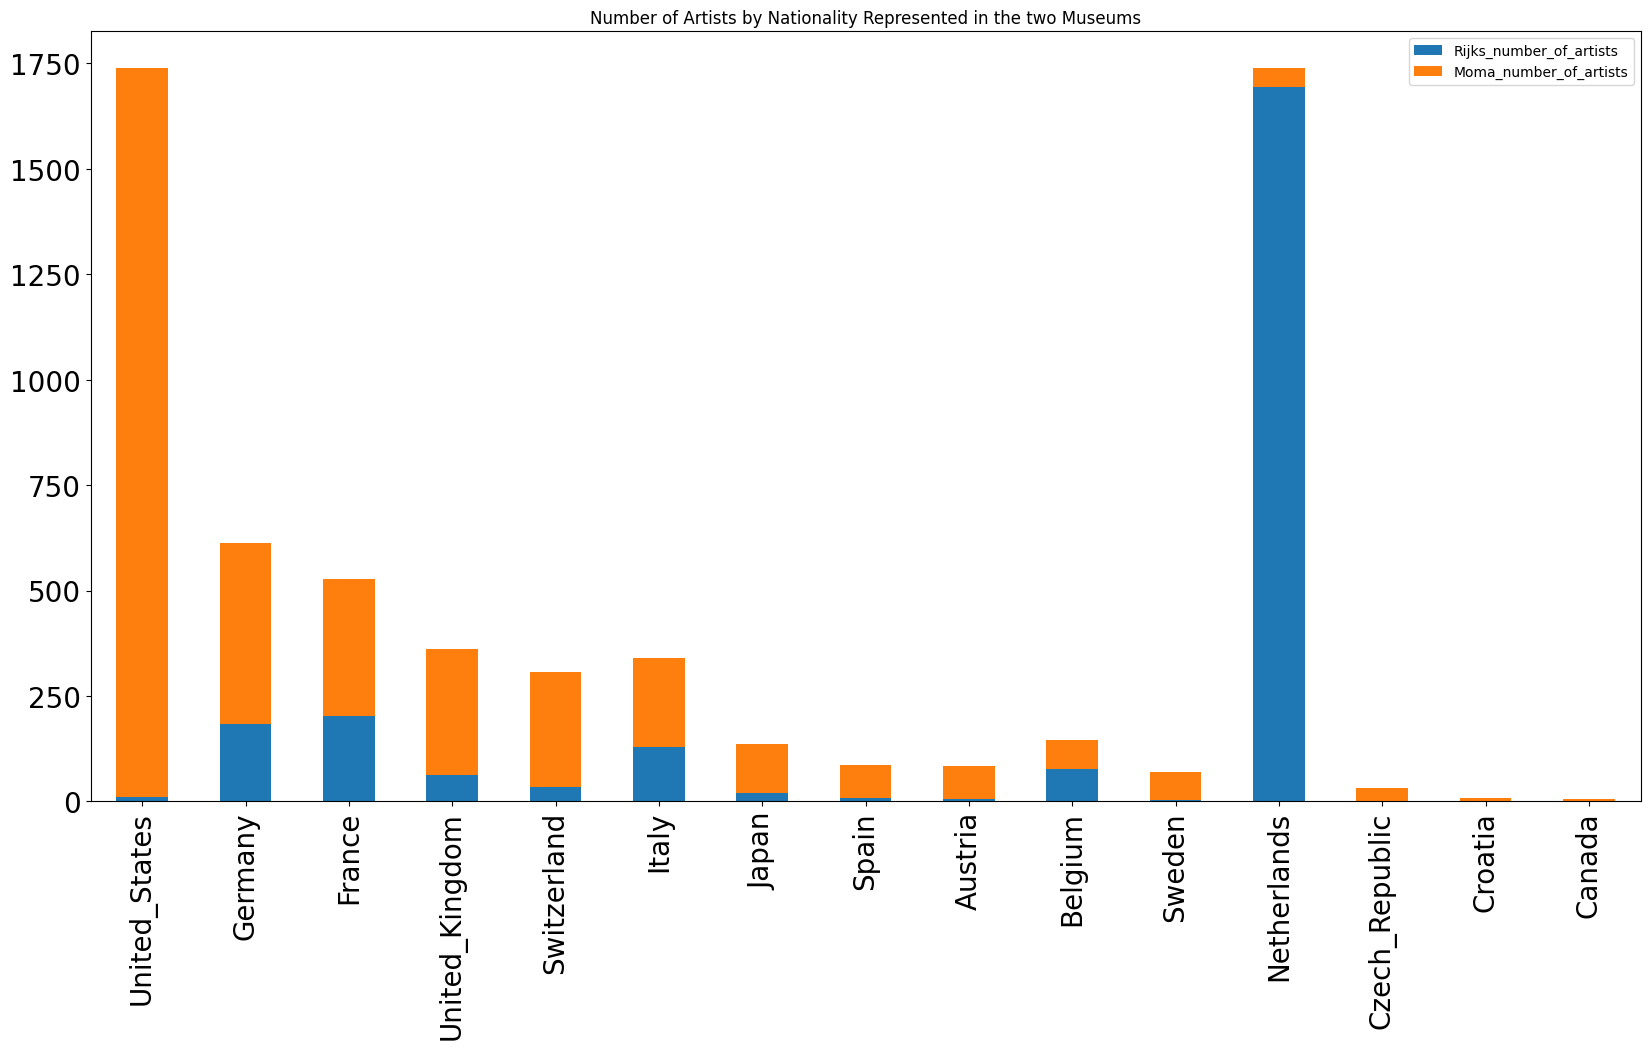

In [71]:
# merge the two dataframes on index and delete the rows with NaN values
df = pd.merge(rijks_df, moma_df, left_index=True, right_index=True)[pd.merge(rijks_df, moma_df, left_index=True, right_index=True).index != 'nan'].sort_values(by=['Moma_number_of_artists'], ascending=False)





# display the dataframe using a bar graph displaying which museume contrubute how many artists


df.plot.bar(title='Number of Artists by Nationality Represented in the two Museums', figsize=(20, 10), fontsize=20, stacked=True)

<p>Now let's try to answer the question: Which periods are the best represented in the Museums? </p>
<p> Let's take all of the data from the museums and group it by the century of the artwork. </p>